# CNN cancer detection

This project aims to create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans. The data was obtained at the Kaggle competition. To complete this challenge, we will use the CNN approach and the Tensorflow Keras package.

## Imports
We will start importing the necessary libraries and data. We will then transform the label dataset so the IDs match the names of the images on the train fold.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import mnist
from PIL import Image
from sklearn.metrics import confusion_matrix

2024-07-26 20:55:03.312951: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-26 20:55:03.313112: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-26 20:55:03.470060: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
labels = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')
data_dir = "../input/histopathologic-cancer-detection/train"
test = "../input/histopathologic-cancer-detection/test"
labels['label'] = labels['label'].astype(str)
labels['id'] = labels['id'].apply(lambda x: x + '.tif')

## Exploratory analyses
We will start our analyses by observing the data images and the dataset. We want to know if both match and how the data is distributed.

In [3]:
print("Number of training images: {}".format(len(os.listdir(data_dir))))
print(labels.info())

Number of training images: 220025
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  object
dtypes: object(2)
memory usage: 3.4+ MB
None


In [4]:
labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


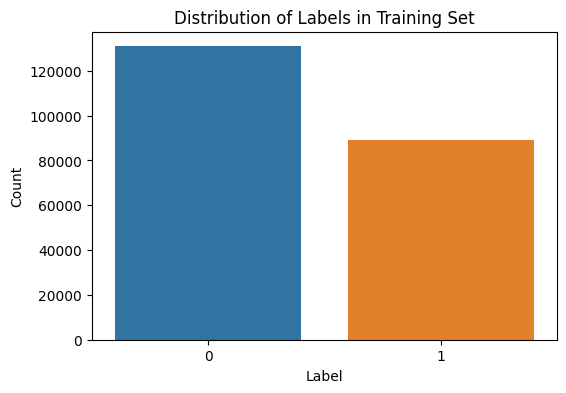

In [5]:
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=labels)
plt.title('Distribution of Labels in Training Set')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

We can observe that there are more non-cancer images than the other way around. We must keep that in mind when training the model to avoid overfitting.

We then rescaled the images, matched them with the labels, and split the dataset into train and validation. We also plotted the images so we could observe cancer versus non-cancer.

In [6]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=.25)

train = datagen.flow_from_dataframe(
    dataframe= labels,
    directory= data_dir,
    x_col='id',
    y_col='label',
    target_size=(60, 60),
    batch_size=256,
    class_mode='binary',
    workers=4,
    use_multiprocessing=True,
    subset='training',
    shuffle=True)
validation = datagen.flow_from_dataframe(
    dataframe= labels,
    directory= data_dir,
    x_col='id',
    y_col='label',
    target_size=(60, 60),
    batch_size=256,
    class_mode='binary',
    workers=4,
    use_multiprocessing=True,
    subset='validation',
    shuffle=True)

Found 165019 validated image filenames belonging to 2 classes.
Found 55006 validated image filenames belonging to 2 classes.


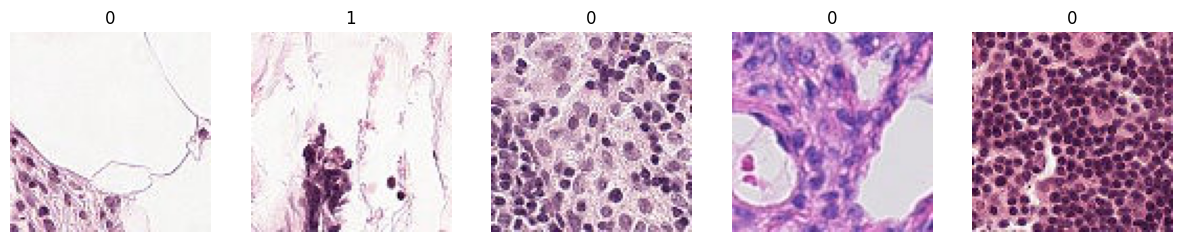

In [7]:
def plot_images(dataframe, directory, n_images=5):
    plt.figure(figsize=(15, 15))
    for i in range(n_images):
        img_path = os.path.join(directory, dataframe.iloc[i]['id'])
        img = Image.open(img_path)
        plt.subplot(1, n_images, i+1)
        plt.imshow(img)
        plt.title(dataframe.iloc[i]['label'])
        plt.axis('off')
    plt.show()

plot_images(labels, data_dir)

## Model
We than creat a sequential model and add multiple layers. Our model has 552650 parameters, all trainable.

In [8]:
target_size = (60,60)
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(target_size[0], target_size[1], 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 58, 58, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 29, 29, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 27, 27, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 11, 11, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 7744)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       495,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 552,650 (2.11 MB)

 Trainable params: 552,650 (2.11 MB)

 Non-trainable params: 0 (0.00 B)

We than compile the model using an adam optimizer and categorical crossentropy loss.

In [10]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

We finally train the model using the data that we preprocess. We use 10 epochs to try to optimize the model. Once the train is over, we have an accuracy of 0.8594 and a loss of 0.3170. Compared to the validation data, the loss is 0.2973, and the accuracy is 0.8739; both are still pretty efficient.

In [11]:
steps_per_epoch = train.samples // train.batch_size
validation_steps = validation.samples // validation.batch_size
model.fit(train,steps_per_epoch=steps_per_epoch,
          epochs=10,
          validation_data=validation,
          validation_steps=validation_steps)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


644/644 ━━━━━━━━━━━━━━━━━━━━ 1294s 2s/step - accuracy: 0.7192 - loss: 0.5692 - val_accuracy: 0.8118 - val_loss: 0.4180
Epoch 2/10
  1/644 ━━━━━━━━━━━━━━━━━━━━ 9:26 881ms/step - accuracy: 0.8281 - loss: 0.3948

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


644/644 ━━━━━━━━━━━━━━━━━━━━ 1s 842us/step - accuracy: 0.8281 - loss: 0.3948 - val_accuracy: 0.8604 - val_loss: 0.3382
Epoch 3/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 748s 1s/step - accuracy: 0.8165 - loss: 0.4113 - val_accuracy: 0.8385 - val_loss: 0.3724
Epoch 4/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 1s 394us/step - accuracy: 0.8203 - loss: 0.3812 - val_accuracy: 0.8739 - val_loss: 0.3464
Epoch 5/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 713s 1s/step - accuracy: 0.8383 - loss: 0.3675 - val_accuracy: 0.8389 - val_loss: 0.3627
Epoch 6/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 1s 299us/step - accuracy: 0.8594 - loss: 0.3317 - val_accuracy: 0.8468 - val_loss: 0.3388
Epoch 7/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 762s 1s/step - accuracy: 0.8486 - loss: 0.3442 - val_accuracy: 0.8475 - val_loss: 0.3483
Epoch 8/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 1s 296us/step - accuracy: 0.8477 - loss: 0.3434 - val_accuracy: 0.8243 - val_loss: 0.4166
Epoch 9/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 715s 1s/step - accuracy: 0.8607 - loss: 0.3235 - val_accuracy: 0

## Conclusions
For our final observations we will plot the accuracy and loss of the model to compared the train vs validation data.

Epoch 1/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 710s 1s/step - accuracy: 0.8703 - loss: 0.3035 - val_accuracy: 0.8720 - val_loss: 0.3033
Epoch 2/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 1s 280us/step - accuracy: 0.9102 - loss: 0.2326 - val_accuracy: 0.8784 - val_loss: 0.2564
Epoch 3/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 687s 1s/step - accuracy: 0.8759 - loss: 0.2910 - val_accuracy: 0.8838 - val_loss: 0.2774
Epoch 4/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 1s 329us/step - accuracy: 0.8906 - loss: 0.2399 - val_accuracy: 0.8514 - val_loss: 0.3193
Epoch 5/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 673s 954ms/step - accuracy: 0.8838 - loss: 0.2756 - val_accuracy: 0.8840 - val_loss: 0.2768
Epoch 6/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 1s 303us/step - accuracy: 0.9023 - loss: 0.2260 - val_accuracy: 0.8829 - val_loss: 0.2540
Epoch 7/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 580s 894ms/step - accuracy: 0.8886 - loss: 0.2648 - val_accuracy: 0.8864 - val_loss: 0.2739
Epoch 8/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 1s 290us/step - accuracy: 0.8984 - loss: 0.2390 

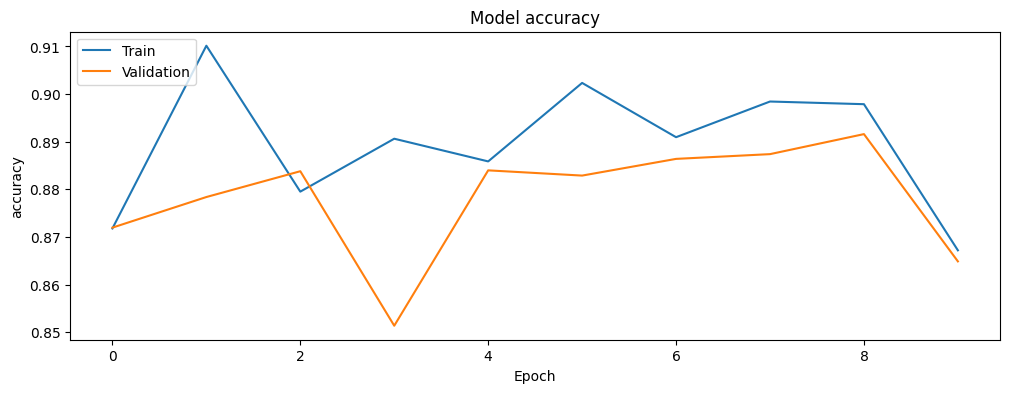

In [12]:
history = model.fit(train,steps_per_epoch=steps_per_epoch,
          epochs=10,
          validation_data=validation,
          validation_steps=validation_steps)
plt.figure(figsize=(12, 4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_' + 'accuracy'])
plt.title('Model ' + 'accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

The model seems to me optimized since the train and validation have high accuracy. The train data is outperforming the validation, but that is expected. Overall, they both still improve with each epoch. Maybe more epochs could be used to fully ensure that the conversion is stabilized.

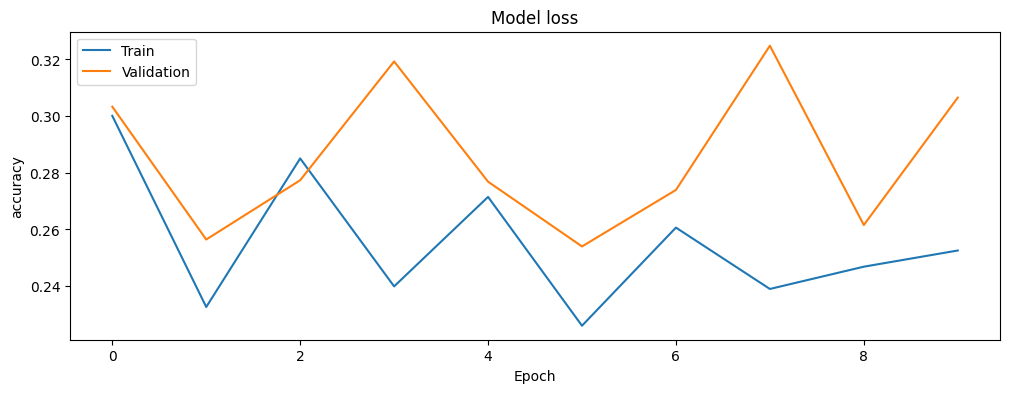

In [13]:
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_' + 'loss'])
plt.title('Model ' + 'loss')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Comparing the loss, both datasets have efficient performances, lowering over the epochs, and alternatin, before stabilize.

## Predictions
Now that our model is fully fuctional we will use it to make predictions, base on the test images. We will start by creating a test data set, with the name of the files as the ids. We than flat the predictors, and calculate the probability of an imagem contain a cancel cell, using a sigmoid normalization. We than determ if a probalility is larger than 0.5 than it is a positive case, if not, it is a 0. 

In [14]:
datagen = ImageDataGenerator(rescale=1./255)

test_files = os.listdir(test)
test_dataframe = pd.DataFrame(test_files, columns=['id'])
test_data_generator = datagen.flow_from_dataframe(dataframe=test_dataframe,
                                                    directory=test,
                                                    x_col='id',
                                                    y_col=None,
                                                    target_size=target_size,
                                                    class_mode=None,
                                                    workers=4,
                                                    use_multiprocessing=True)

Found 57458 validated image filenames.


In [15]:
pred = model.predict(test_data_generator)
predictions = np.transpose(pred)[0]

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 342s 191ms/step


In [16]:
#pred_flat = pred[:,1]
#def sigmoid(x):
#    return 1 / (1 + np.exp(-x))
#pred_probs = sigmoid(pred_flat)

In [17]:
pred_binary = (predictions > 0.5).astype(int).flatten()
submission_dataframe = pd.DataFrame()
submission_dataframe['id'] = test_dataframe['id'].apply(lambda x: x.split('.')[0]) 
submission_dataframe['label'] = pred_binary
submission_dataframe.to_csv('submission.csv', index=False)